## Part A: Examine training sets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
import random
from sklearn.model_selection import KFold

df1 = pd.read_csv("train1.csv")
df1 = df1.iloc[:, 1:4]
df2 = pd.read_csv("train2.csv")
df2 = df2.iloc[:, 1:4]

In [2]:
print(df1)
print(df1.keys())
df1_numpy = df1.values
print(df1_numpy)

             0         1    2
0     3.545470  2.783637  0.0
1    -0.049965  1.401139  1.0
2    -0.345808  4.097528  1.0
3    -0.224355  3.964598  1.0
4    -1.511867  5.353938  1.0
...        ...       ...  ...
3995  0.617500  4.977189  1.0
3996  2.283821  1.907379  0.0
3997  3.410391  1.077821  0.0
3998  3.228921  2.579027  0.0
3999  1.626419  2.763415  0.0

[4000 rows x 3 columns]
Index(['0', '1', '2'], dtype='object')
[[ 3.54546992  2.7836371   0.        ]
 [-0.04996543  1.40113893  1.        ]
 [-0.34580826  4.09752756  1.        ]
 ...
 [ 3.4103915   1.07782135  0.        ]
 [ 3.22892136  2.57902719  0.        ]
 [ 1.62641942  2.76341503  0.        ]]


Dataset 1:
Covariance matrix for class c0:
[[0.68091842 0.0081905 ]
 [0.0081905  0.39290762]]


C:\Users\Furkan\AppData\Local\Temp/ipykernel_10428/742972005.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
C:\Users\Furkan\AppData\Local\Temp/ipykernel_10428/742972005.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


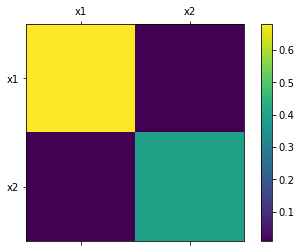

Covariance matrix for class c1:
[[0.35380673 0.00907201]
 [0.00907201 1.43810939]]


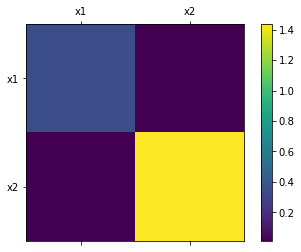

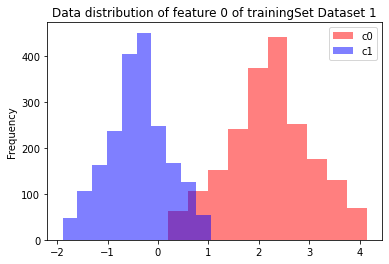

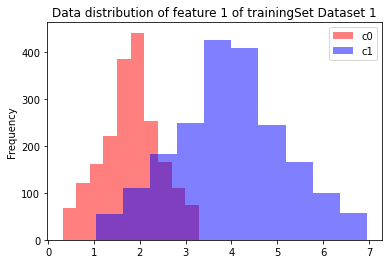

Data Scatter:


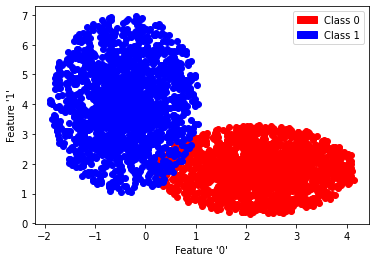

--------------------
Dataset 2:
Covariance matrix for class c0:
[[0.43328013 0.09444427]
 [0.09444427 0.06674601]]


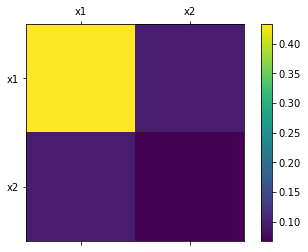

Covariance matrix for class c1:
[[0.43333327 0.09428412]
 [0.09428412 0.06666807]]


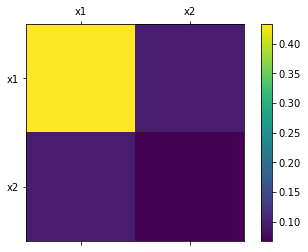

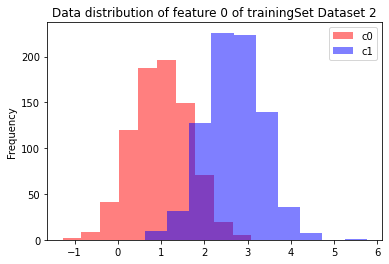

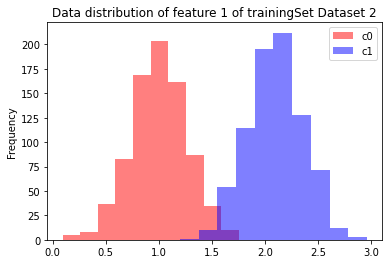

Data Scatter:


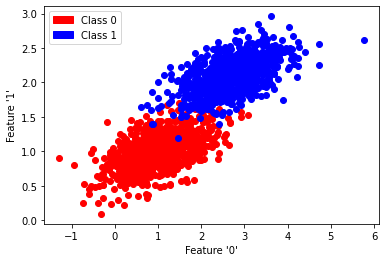

--------------------


In [11]:
def dump_cov_mat(class_samples, class_label):
    """
    Prints and plots the covariance matrices for given samples and their corresponding labels.
    """
    cov_mat = np.cov(class_samples.T)
    print(f"Covariance matrix for class {class_label}:\n{cov_mat}")
    alpha = ['x1', 'x2']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cov_mat, interpolation='nearest')
    fig.colorbar(cax)
    ax.set_xticklabels(['']+alpha)
    ax.set_yticklabels(['']+alpha)
    plt.show()
    
def plot_dataset(data_frame, df_name):
    """
    Plots covariance matrices, feature histograms, and data scatters for given data frame. 
    """
    df_data = data_frame.values[:,0:2]
    df_labels = data_frame.values[:, 2]
    c0 = df_data[df_labels==0]
    c1 = df_data[df_labels==1]
    print(f'{df_name}:')
    dump_cov_mat(c0, 'c0')
    dump_cov_mat(c1, 'c1')
    plt.gca().set(title=f'Data distribution of feature 0 of trainingSet {df_name}', ylabel='Frequency')
    plt.hist(data_frame['0'][df_labels==0], alpha=0.5, label='c0', color='red')
    plt.hist(data_frame['0'][df_labels==1], alpha=0.5, label='c1', color='blue')
    plt.legend()
    plt.show()
    plt.gca().set(title=f'Data distribution of feature 1 of trainingSet {df_name}', ylabel='Frequency')
    plt.hist(data_frame['1'][df_labels==0], alpha=0.5, label='c0', color='red')
    plt.hist(data_frame['1'][df_labels==1], alpha=0.5, label='c1', color='blue')
    plt.legend()
    plt.show()
    print("Data Scatter:")
    plt.scatter(c0[:, 0], c0[:, 1], c='red')
    plt.scatter(c1[:, 0], c1[:, 1], c='blue')
    plt.xlabel("Feature '0'")
    plt.ylabel("Feature '1'")
    plt.legend(handles=[matplotlib.patches.Patch(color='red', label='Class 0'), matplotlib.patches.Patch(color='blue', label='Class 1')])
    plt.show()
    print('-' * 20)
    
plot_dataset(df1, "Dataset 1")
plot_dataset(df2, "Dataset 2")

It can be seen that, for both datasets, covariance matrices are almost diagonal, meaning that features in each of the classes have almost no correlation and they are independent. This means that we can use Naive Bayes classification to build an effective model, since Naive Bayes' assumption is exactly that.

Also, for dataset 2, covariance matrices of the classes are equal (under tolerance), so linear discriminant analysis can be applied on it, whereas since dataset 1 does not satisfy that, quadratic discriminant analysis can be applied on it.

About feature histograms, they do not have much overlapping. Since overlapping makes it harder to linearly separate classes, they are somewhat linearly separable (not perfectly), and this can be seen from the scatter plots as well.

## Part B: Evaluation of Parametric classifier

In [12]:
def train_bayes(X, y):
    """
    Trains and returns a parametric classifier (a function).
    """
    labels = np.unique(y)
    mean_vecs = {}
    cov_mats = {}
    label_ratios = {}
    for label in labels:
        label_samples = X[y == label]
        mean_vecs[label] = np.mean(label_samples, axis=0)
        print(f"Mean vector for class {label}:", mean_vecs[label], sep='\n')
        cov_mats[label] = np.cov(label_samples.T)
        print(f"Covariance matrix for class {label}:", cov_mats[label], sep='\n')
        label_ratios[label] = len(label_samples) / len(X)

    covariance_matrices_are_equal = True
    for idx in range(len(labels)):
        for idx2 in range(idx + 1, len(labels)):
            if not np.allclose(cov_mats[labels[idx]], cov_mats[labels[idx2]], rtol=0, atol=1e-3):
                covariance_matrices_are_equal = False
                break
        else:  
            continue
        break
                
    def classifier(X):
        """
        Classifies and returns the labels for given samples (X).
        """
        predicted_labels = np.array([])
        for x in X:
            max_val = -float('inf')
            predicted_label = None
            for label in labels:  # Iterate for the label that gives the maximum LDA or QDA value
                if covariance_matrices_are_equal:  # Linear discriminant analysis
                    inv_cov_mat = np.linalg.inv(cov_mats[label])
                    value = x.T @ inv_cov_mat @ mean_vecs[label] - 0.5 * mean_vecs[label].T @ inv_cov_mat @ mean_vecs[label] + math.log(label_ratios[label])
                else:  # Quadratic discriminant analysis
                    inv_cov_mat = np.linalg.inv(cov_mats[label])
                    value = -0.5 * math.log(np.linalg.det(cov_mats[label])) - 0.5 * (x - mean_vecs[label]).T @ inv_cov_mat @ (x - mean_vecs[label]) + math.log(label_ratios[label])
                if value > max_val:
                    max_val = value
                    predicted_label = label
            predicted_labels = np.append(predicted_labels, predicted_label)
        return predicted_labels
    
    return classifier

In [5]:
def train_test_classifier(train_df, test_df):
    classifier = train_bayes(train_df.values[:,0:2], train_df.values[:,2])
    
    test_df_X = test_df.iloc[:, 0:2]
    test_df_y = test_df.iloc[:, 2]
    predictions = classifier(test_df_X.values)
    misclassification_count = np.sum(test_df_y.values != predictions)
    error_rate = 100 * misclassification_count / len(test_df)
    return error_rate

test_df1 = pd.read_csv("test1.csv") 
test_df1 = test_df1.iloc[:, 1:4]
test_df2 = pd.read_csv("test2.csv")
test_df2 = test_df2.iloc[:, 1:4]

print(f"Error rate for dataset 1: %{train_test_classifier(df1, test_df1)}")
print("-" * 20)
print(f"Error rate for dataset 2: %{train_test_classifier(df2, test_df2)}")

Mean vector for class 0.0:
[2.21769596 1.81682192]
Covariance matrix for class 0.0:
[[0.68091842 0.0081905 ]
 [0.0081905  0.39290762]]
Mean vector for class 1.0:
[-0.40657297  3.97311422]
Covariance matrix for class 1.0:
[[0.35380673 0.00907201]
 [0.00907201 1.43810939]]
Error rate for dataset 1: %1.2
--------------------
Mean vector for class 0.0:
[1. 1.]
Covariance matrix for class 0.0:
[[0.43328013 0.09444427]
 [0.09444427 0.06674601]]
Mean vector for class 1.0:
[2.7 2.1]
Covariance matrix for class 1.0:
[[0.43333327 0.09428412]
 [0.09428412 0.06666807]]
Error rate for dataset 2: %2.0


## Part C: Principal Component Analysis

In [6]:
def PCA(X, k=None, varRetained = 0.95, show = False):
    """
    Performs Principal Component Analysis and returns tuple (projection matrix, projected features).
    """
    X_m = X - np.mean(X, axis=0)
    cov_mat = np.cov(X_m.T)
    eig_vals, eig_vecs = np.linalg.eigh(cov_mat)
    sort_indexes = np.argsort(eig_vals)
    eig_vals, eig_vecs = eig_vals[sort_indexes], eig_vecs[sort_indexes]  # Sort eigenvalues and eigenvectors ascending
    eig_val_sum = np.sum(eig_vals)
    
    variance_values = []  # Variances in the #features-%variance graph
    cumulative_var_retained = 0
    dim_count = 0  # Holds the feature count in the output, if k is not given (None).
    for idx, eig_val in enumerate(reversed(eig_vals)):  # Iterate through eigenvalues (descending) and stop incrementing dimension count when desired variance is retained 
        curr_var_retained = (eig_val / eig_val_sum)
        if cumulative_var_retained < varRetained:
            dim_count += 1
        cumulative_var_retained += curr_var_retained
        variance_values.append(cumulative_var_retained * 100)
    variance_values.extend([100] * (X.shape[1] - len(eig_vals)))  # Pad the array to match the number of original features

    if show:
        print("%Variance vs #Features Line:")
        plt.plot([*range(1, X.shape[1] + 1)], variance_values)
        plt.xticks([*range(1, X.shape[1] + 1)])
        plt.xlabel("# of features")
        plt.ylabel("% retained variance")
        plt.show()
    
    if k is None:
        k = dim_count  # k is the variable to determine the feature count in the output
    projection_matrix = pd.DataFrame(eig_vecs[len(eig_vecs) - k::-1].T)  # Select the appropriate subset of eigenvectors, whose length is k
    reduced_features = pd.DataFrame(np.dot(eig_vecs, X_m.T).T)  # Apply the projection on the input features
    return projection_matrix, reduced_features

Iris Dataset:
Scatter plot of the original data:


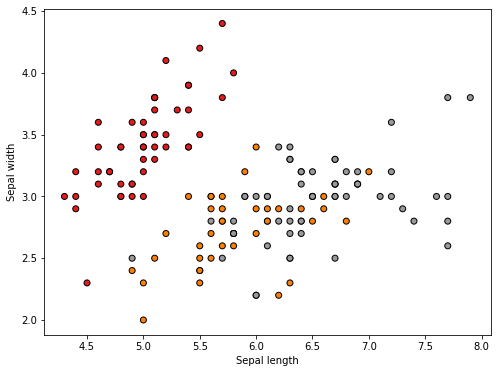

%Variance vs #Features Line:


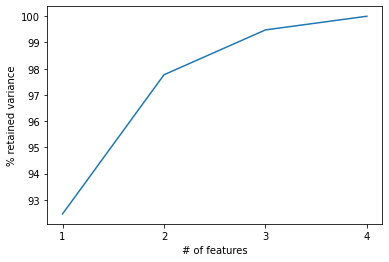

Scatter plot of the projected data:


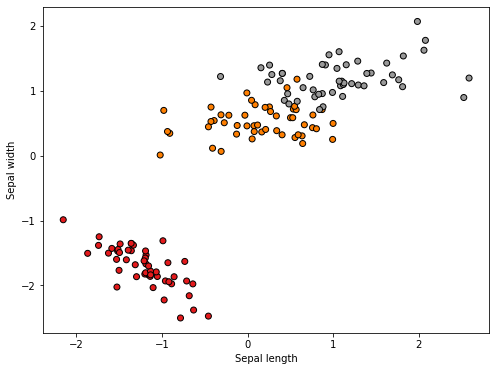

Breast Cancer Dataset:
Scatter plot of the original data:


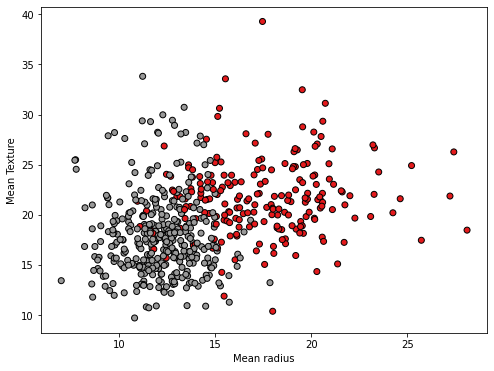

%Variance vs #Features Line:


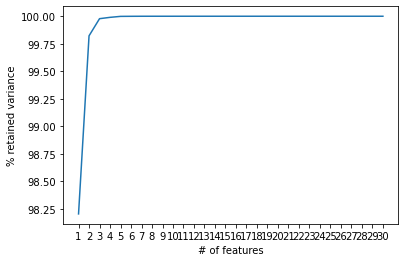

Scatter plot of the projected data:


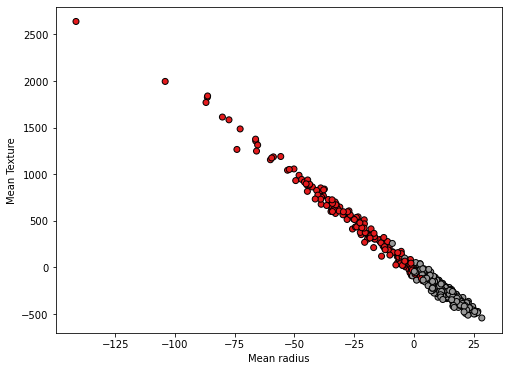

In [7]:
from sklearn import datasets

def scatter_plot(X, y, x_label, y_label):
    plt.figure(2, figsize=(8, 6))
    plt.clf()
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
iris = datasets.load_iris(as_frame=True)
iris_X = iris.data
iris_y = iris.target

print("Iris Dataset:")
print("Scatter plot of the original data:")
scatter_plot(iris_X, iris_y, "Sepal length", "Sepal width")

_, iris_X = PCA(iris_X, k=2, show=True)
print("Scatter plot of the projected data:")
scatter_plot(iris_X, iris_y, "Sepal length", "Sepal width")

print("Breast Cancer Dataset:")
breast_cancer = datasets.load_breast_cancer(as_frame=True)
breast_cancer_X = breast_cancer.data
breast_cancer_y = breast_cancer.target

print("Scatter plot of the original data:")
scatter_plot(breast_cancer_X, breast_cancer_y, "Mean radius", "Mean Texture")

_, breast_cancer_X = PCA(breast_cancer_X, k=2, show=True)
print("Scatter plot of the projected data:")
scatter_plot(breast_cancer_X, breast_cancer_y, "Mean radius", "Mean Texture")

### Evaluation

- For Iris dataset, PCA made it possible to linearly separate the classes, this is because PCA led to a change in the feature space. As can be seen from the (number of features-%retained variance) graph, as we increase the number of features, captured variance also increases. Our aim is to start from the most principal feature (which is the one with the most retained variance), and form a projection matrix, after that project the input using this matrix, considering the desired K and retained variance parameters while doing all of this. One of the advantages of PCA is to project the features onto dimensions which we are able to interpret (1d,2d,3d) (regardless of the dataset size), another advantage is, as can be seen from the Iris plots, allows linear separation of classes (increases the performance of learning algorithms) with the introduction of a new space.

- For breast cancer dataset, PCA also changed the space and allowed linear separation.

- Feature selection is the direct selection of a subset of the original features (also can be expressed as elimination of some columns). On the other hand, feature extraction makes the output features to carry the characteristics of the original features, so it is not the direct selection of features. PCA falls under feature extraction, since it makes a projection operation on the input features.

- PCA can only work when there is a correlation between features. If this assumption is not provided, PCA fails to obtain the principal components.

- It is so important to standardize data before applying PCA, because for example, if a feature takes values between 1 and 10000, and another one takes between 1 and 10, their scales of variances would be massively different, and PCA would be biased towards the first feature when looking for the principal component.

## References

https://www.byclb.com/TR/Tutorials/neural_networks/ch9_1.htm

https://www.sartorius.com/en/knowledge/science-snippets/what-is-principal-component-analysis-pca-and-how-it-is-used-507186